<font size='5'>Variational Inference - An unsupervised time series clustering approach</font>

Using variational inference applied to time series data, the algorithm non-parametrically chooses a likely number of clusters each with distinct <b>mean and covariance</b> parameters allowing computation of a likelihood function for the 3-dimensional point at any time step. The model optimizes the parameters of the i clusters to maximize the likelihood of those parameters given the data. Similarity between probability distributions is measured via the KL-divergence. Comparing the distributions at each of the i-th clusters and then deriving a total entropy score:

$D_{KL}(P \parallel Q) = \sum_{i} P(i) \log \frac{P(i)}{Q(i)}$

In practice this works out to function as an unsupervised classification algorithm for the most likely distribution (mean and covariance) a time step belongs to. This is applicable to discovering statistical market regime-shifts where the parameters of interest (mean and covariance) are shifting.

This variant of the notebook will sample from the posterior distribution over the parameters of the latent states, and their transition matrix that gives us a probability of switching to any given state based on the empirically observed data.

In [211]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 

import sklearn 
import sklearn.mixture as mix 

from scipy.special import softmax
from scipy.stats import entropy

Testing a small universe of the 10Y Treasury, a Commodity ETF, and Tech ETF. The goal will be time series clustering using variational inference. There are periods of time (regimes) where certain assets outperform the others and their precise relationship is captured in each cluster. 

Set num_components to a very high number so the data is fit in a non-parametric way where we need not know the number of clusters in advance. 

In [212]:
assetlist = [ 'IEF', 'GSG', 'IXN' ]
num_components = 99

Create the subset of assets.

In [213]:
m6 = pd.read_csv('./data/assets_m6.csv')
m6_assets = pd.DataFrame()

for sym in assetlist: 
    m6_assets[sym] = m6[m6['symbol'] == sym]['price'].values

Formatting the training data. 1st-order differencing of the log price for each asset. View auto-correlation.

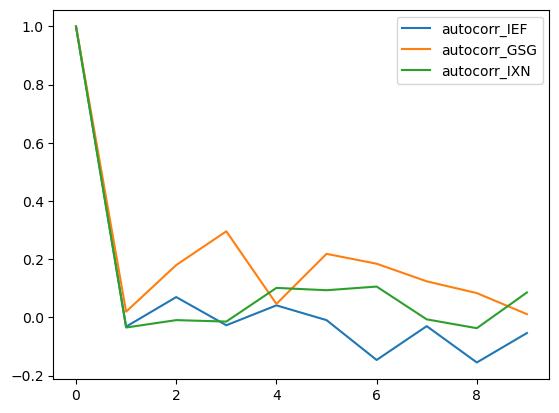

In [214]:
m6_subset = m6_assets.copy().apply(np.log).apply(np.diff)
m6_subset = m6_subset.dropna().reset_index().drop(columns='index')

autocorr_df = pd.DataFrame()
autocorr_df['decay_IEF'] = m6_subset['IEF'].apply(abs)
autocorr_df['decay_GSG'] = m6_subset['GSG'].apply(abs) 
autocorr_df['decay_IXN'] = m6_subset['IXN'].apply(abs) 
decay_func = lambda S, _range: [S.autocorr(lag=Lag) for Lag in _range]

sns.lineplot(data=decay_func(autocorr_df['decay_IEF'], range(0, 10)), label='autocorr_IEF') 
sns.lineplot(data=decay_func(autocorr_df['decay_GSG'], range(0, 10)), label='autocorr_GSG')
sns.lineplot(data=decay_func(autocorr_df['decay_IXN'], range(0, 10)), label='autocorr_IXN')
plt.show()

Instantiate a non-parametric clustering model using the dirichlet process. 

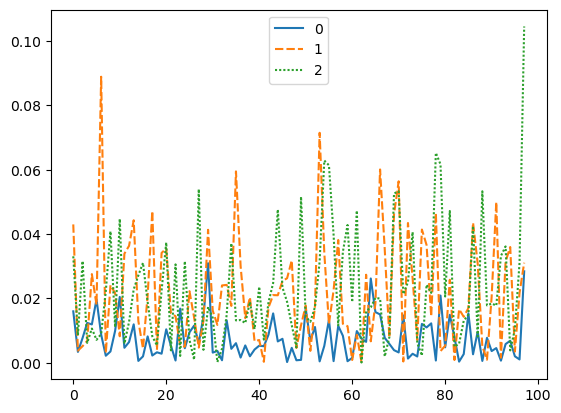

In [215]:
walkforward_results = [] 
residuals = []

local_model = mix.BayesianGaussianMixture(n_components=num_components, weight_concentration_prior_type='dirichlet_process', warm_start=True)

for w in range(num_components, len(m6_subset) - 1):
    
    local_model = local_model.fit(m6_subset[w-num_components:w])
    sample, y = local_model.sample(1)

    walkforward_results.append(sample[0]) 
    
    ief=abs(sample[0][0] - (m6_subset.iloc[w]['IEF']))
    gsg=abs(sample[0][1] - (m6_subset.iloc[w]['GSG']))
    ixn=abs(sample[0][2] - (m6_subset.iloc[w]['IXN']))

    residuals.append([ ief, gsg, ixn ])

get_col = lambda sampler, M: [ s[M] for s in sampler ]

df = pd.DataFrame()
df['0']=get_col(residuals, 0)
df['1']=get_col(residuals, 1)
df['2']=get_col(residuals, 2)

sns.lineplot(data=df)
plt.show()

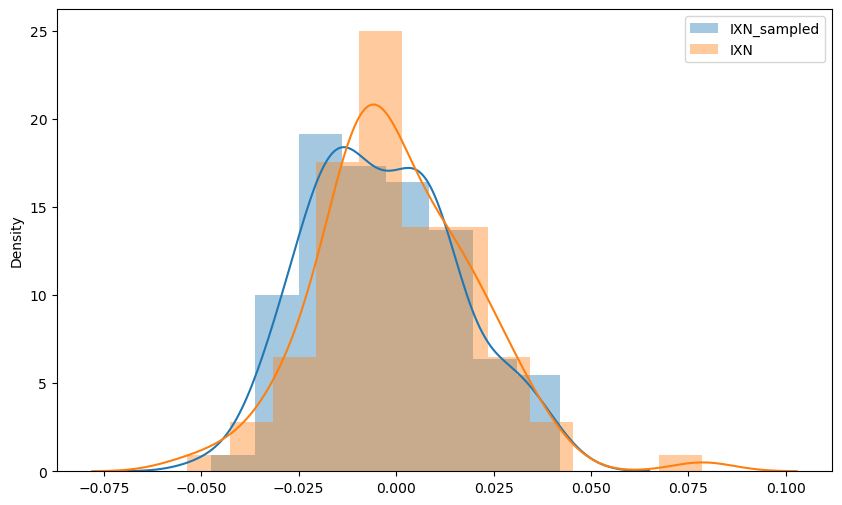

---KL divergence---
0.00035620604710326576


In [216]:
fig,ax = plt.subplots(figsize=(10, 6))
 
df_pst = pd.DataFrame()
df_pst['IEF_sampled']=get_col(walkforward_results, 0)
df_pst['GSG_sampled']=get_col(walkforward_results, 1)
df_pst['IXN_sampled']=get_col(walkforward_results, 2)
 
in_sample = m6_subset['IXN'][num_components + 1:].astype(float).values 
out_of_sample = df_pst['IXN_sampled'].astype(float).values

sns.distplot(out_of_sample, label='IXN_sampled')
sns.distplot(in_sample, label='IXN')
plt.legend()
plt.show()

print('---KL divergence---')
print(entropy(softmax(out_of_sample), softmax(in_sample)))